In [17]:
%matplotlib inline
import pylab
import pandas as pd
import glob
from collections import defaultdict
import sourmash
from sourmash.lca import lca_utils

In [2]:
sample_id='SRR1976948'
#sample_id = 'p8808mo9'
#sample_id = 'p8808mo11'
outdir = 'outputs'


In [3]:
from IPython.display import Markdown as md
from IPython.display import display
md(f"# genome-grist taxonomic report for metagenome `{sample_id}`")

# genome-grist report for metagenome `SRR1976948`

## load mapping summary CSVs and gather CSV

In [4]:

# load mapping CSVs
all_df = pd.read_csv(f'../../{outdir}/minimap/depth/{sample_id}.summary.csv')
left_df = pd.read_csv(f'../../{outdir}/leftover/depth/{sample_id}.summary.csv')

# load gather CSV
gather_df = pd.read_csv(f'../../{outdir}/genbank/{sample_id}.x.genbank.gather.csv')

# names!
names_df = pd.read_csv(f'../../{outdir}/genbank/{sample_id}.genomes.info.csv')

# connect gather_df to all_df and left_df using 'genome_id'
def fix_name(x):
    return "_".join(x.split('_')[:2]).split('.')[0]

gather_df['genome_id'] = gather_df['name'].apply(fix_name)
names_df['genome_id'] = names_df['acc'].apply(fix_name)

In [5]:
# CTB bug FIXME - should this ever happen??
# this ensures that only rows that share genome_id are in all the dataframes
in_gather = set(gather_df.genome_id)
in_left = set(left_df.genome_id)

in_both = in_left.intersection(in_gather)

all_df = all_df[all_df.genome_id.isin(in_both)]
left_df = left_df[left_df.genome_id.isin(in_both)]
gather_df = gather_df[gather_df.genome_id.isin(in_both)]
names_df = names_df[names_df.genome_id.isin(in_both)]

# reassign index now that we've maybe dropped rows
all_df.index = range(len(all_df))
left_df.index = range(len(left_df))
gather_df.index = range(len(gather_df))
names_df.index = range(len(names_df))

assert len(all_df) == len(gather_df)
assert len(left_df) == len(gather_df)
assert len(names_df) == len(gather_df)

In [14]:
# re-sort left_df and all_df to match gather_df order, using matching genome_id column
all_df.set_index("genome_id")
all_df.reindex(index=gather_df["genome_id"])
all_df.reset_index()

left_df.set_index("genome_id")
left_df.reindex(index=gather_df["genome_id"])
left_df.reset_index()

#left_df["mapped_bp"] = (1 - left_df["percent missed"]/100) * left_df["genome bp"]
#left_df["unique_mapped_coverage"] = left_df.coverage / (1 - left_df["percent missed"] / 100.0)

names_df.set_index("genome_id")
names_df.reindex(index=gather_df["genome_id"])
_ = names_df.reset_index()


In [15]:
# load and parse lineages
lineage_files = glob.glob('../../genbank_lineages/*.csv')

lineages_df = pd.DataFrame()

for filename in lineage_files:
    print(f"reading {filename}")
    this_df = pd.read_csv(filename)
    this_df = this_df[this_df.accession.isin(in_both)]
    lineages_df = lineages_df.append(this_df)
    
lineages_df

reading ../../genbank_lineages/viral_genbank_lineage.csv
reading ../../genbank_lineages/protozoa_refseq_lineage.csv
reading ../../genbank_lineages/bacteria_genbank_lineage.csv
reading ../../genbank_lineages/protozoa_genbank_lineage.csv
reading ../../genbank_lineages/fungi_genbank_lineage.csv
reading ../../genbank_lineages/archaea_genbank_lineage.csv
reading ../../genbank_lineages/viral_refseq_lineage.csv
reading ../../genbank_lineages/bacteria_refseq_lineage.csv
reading ../../genbank_lineages/archaea_refseq_lineage.csv
reading ../../genbank_lineages/fungi_refseq_lineage.csv


,accession,taxid,superkingdom,phylum,class,order,family,genus,species,strain
62830,GCA_002890795,316,Bacteria,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Pseudomonadaceae,Pseudomonas,Pseudomonas stutzeri,NaN
62836,GCA_002890955,316,Bacteria,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Pseudomonadaceae,Pseudomonas,Pseudomonas stutzeri,NaN
87568,GCA_003176515,562,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Escherichia,Escherichia coli,NaN
556734,GCA_001887715,29542,Bacteria,Proteobacteria,Deltaproteobacteria,Desulfuromonadales,Desulfuromonadaceae,Pelobacter,Pelobacter acetylenicus,NaN
563404,GCA_003445665,41211,Bacteria,Firmicutes,Clostridia,Clostridiales,Peptococcaceae,Desulfotomaculum,Desulfotomaculum sp.,NaN
...,...,...,...,...,...,...,...,...,...,...
3037,GCA_002839645,2013818,Archaea,Euryarchaeota,Methanomicrobia,Methanomicrobiales,NaN,NaN,Methanomicrobiales archaeon HGW-Methanomicrobi...,NaN
3041,GCA_002839575,2013822,Archaea,Euryarchaeota,Methanomicrobia,Methanomicrobiales,NaN,NaN,Methanomicrobiales archaeon HGW-Methanomicrobi...,NaN
5082,GCA_011620825,2517205,Archaea,Euryarchaeota,Thermoplasmata,Methanomassiliicoccales,Candidatus Methanomethylophilaceae,NaN,Candidatus Methanomethylophilaceae archaeon,NaN
5083,GCA_013329105,2517205,Archaea,Euryarchaeota,Thermoplasmata,Methanomassiliicoccales,Candidatus Methanomethylophilaceae,NaN,Candidatus Methanomethylophilaceae archaeon,NaN


In [19]:
# build a new dataframe that has a single column of lineages in it
def make_combined_lineage(row):
    x = []
    for rank in ('superkingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species'):
        name = getattr(row, rank)
        # turn NaN/empty into ''
        if pd.isnull(name):
            name = ''
        x.append(lca_utils.LineagePair(rank, name))
    return dict(genome_id=row.accession, combined_lineage=tuple(x))

lineages2_df = lineages_df.apply(make_combined_lineage, axis=1, result_type='expand')

lineages2_df.set_index("genome_id")
lineages2_df.reindex(index=gather_df["genome_id"])
_ = lineages2_df.reset_index()

In [20]:
# build a merged df that contains stuff from gather_df and from left_df
merged_lin_df = gather_df.merge(lineages2_df[['genome_id','combined_lineage']], on='genome_id', how='left')
merged_lin_df = merged_lin_df.merge(left_df[['genome_id','covered_bp']], on='genome_id', how='left')

merged_lin_df[["genome_id", "name", "combined_lineage", "covered_bp"]]

,genome_id,name,combined_lineage,covered_bp
0,GCA_003446605,"GCA_003446605.1 Anaerolineaceae bacterium, ASM...","((superkingdom, Bacteria), (phylum, Chloroflex...",2650062.0
1,GCA_003500195,"GCA_003500195.1 Clostridiales bacterium, ASM35...","((superkingdom, Bacteria), (phylum, Firmicutes...",2500855.0
2,GCA_002503885,"GCA_002503885.1 Methanoculleus marisnigri, ASM...","((superkingdom, Archaea), (phylum, Euryarchaeo...",2573370.0
3,GCA_003451675,GCA_003451675.1 Candidatus Atribacteria bacter...,"((superkingdom, Bacteria), (phylum, Candidatus...",2567325.0
4,GCA_003445665,"GCA_003445665.1 Desulfotomaculum sp., ASM344566v1","((superkingdom, Bacteria), (phylum, Firmicutes...",2536313.0
...,...,...,...,...
157,GCA_002890955,GCA_002890955.1 Pseudomonas stutzeri strain=ST...,"((superkingdom, Bacteria), (phylum, Proteobact...",100460.0
158,GCA_003194365,"GCA_003194365.1 Mesotoga sp. SC_NapDC, ASM3194...","((superkingdom, Bacteria), (phylum, Thermotoga...",35753.0
159,GCA_002452585,GCA_002452585.1 Kosmotogaceae bacterium UBA681...,"((superkingdom, Bacteria), (phylum, Thermotoga...",56299.0
160,GCA_002329445,"GCA_002329445.1 bacterium UBP9_UBA1432, ASM232...","((superkingdom, Bacteria), (phylum, ), (class,...",24675.0


In [22]:
# create function that aggregates various pieces of information by rank & builds a new df
def aggregate_by_rank(df, rank):
    # first, build all the counts
    unique_intersect_by_rank = defaultdict(int)
    best_hashes_by_rank = {}
    covered_bp_by_rank = defaultdict(int)

    def sum_unique(row):
        lin = row.combined_lineage
        unique_hashes = row.unique_intersect_bp
        covered_bp = row.covered_bp

        for rank in ('superkingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species'):
            poplin = lca_utils.pop_to_rank(lin, rank)
            unique_intersect_by_rank[poplin] += unique_hashes
            covered_bp_by_rank[poplin] += int(covered_bp)
            
            best_hashes = best_hashes_by_rank.get(poplin, 0)
            if best_hashes < unique_hashes:
                best_hashes_by_rank[poplin] = unique_hashes

    df.apply(sum_unique, axis=1)

    # now do the sorting etc.
    rank_counts = []
    for lin, bp in sorted(unique_intersect_by_rank.items(), key=lambda x: -x[1]):
        if lin[-1].rank == rank:
            
            if rank == 'species':
                name = lin[-1].name
                name = f'{name} ({lin[0].name})'
            else:
                name = lca_utils.display_lineage(lin)

            rank_counts.append(dict(name=name, hashes=bp,
                                    mapped=covered_bp_by_rank[lin],
                                    best_hashes=best_hashes_by_rank[lin],
                                    lineage=lin))

    return pd.DataFrame(rank_counts)

saving to /tmp/gathertax-species-SRR1976948.png


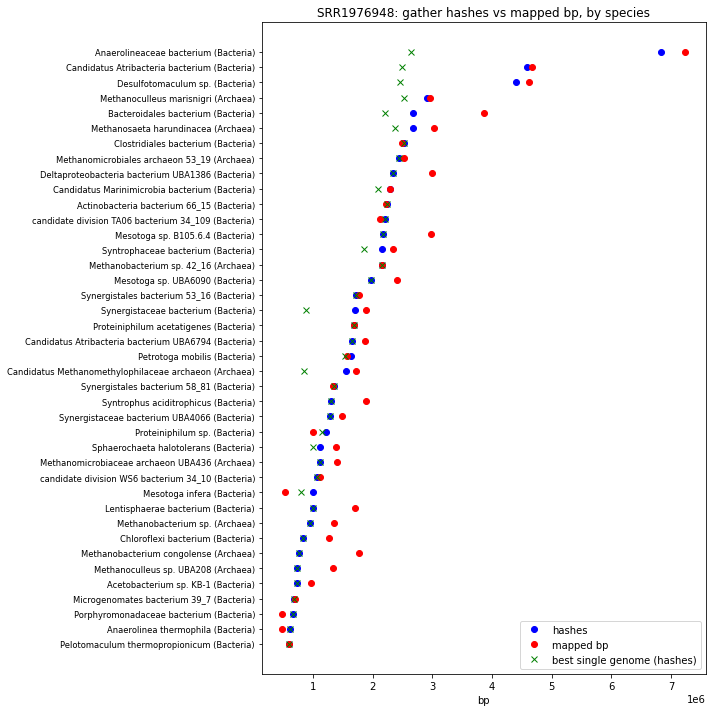

In [24]:
rank = 'species'

pylab.figure(num=None, figsize=(10, 10))

rank_counts_df = aggregate_by_rank(merged_lin_df, rank)

plot_df = rank_counts_df[:40]
pylab.plot(plot_df.hashes, plot_df.iloc[::-1].index, 'bo', label='hashes')
pylab.plot(plot_df.mapped, plot_df.iloc[::-1].index, 'ro', label='mapped bp')
pylab.plot(plot_df.best_hashes, plot_df.iloc[::-1].index, 'gx', label='best single genome (hashes)')

positions = list(plot_df.index)
labels = list(reversed(plot_df.name))
pylab.yticks(positions, labels, fontsize='small')

pylab.xlabel('bp')
pylab.legend(loc='lower right')
pylab.title(f'{sample_id}: gather hashes vs mapped bp, by {rank}')
pylab.tight_layout()

figname = f'/tmp/gathertax-{rank}-{sample_id}.png'
print(f'saving to {figname}')
pylab.savefig(figname)

saving to /tmp/gathertax-phylum-SRR1976948.png


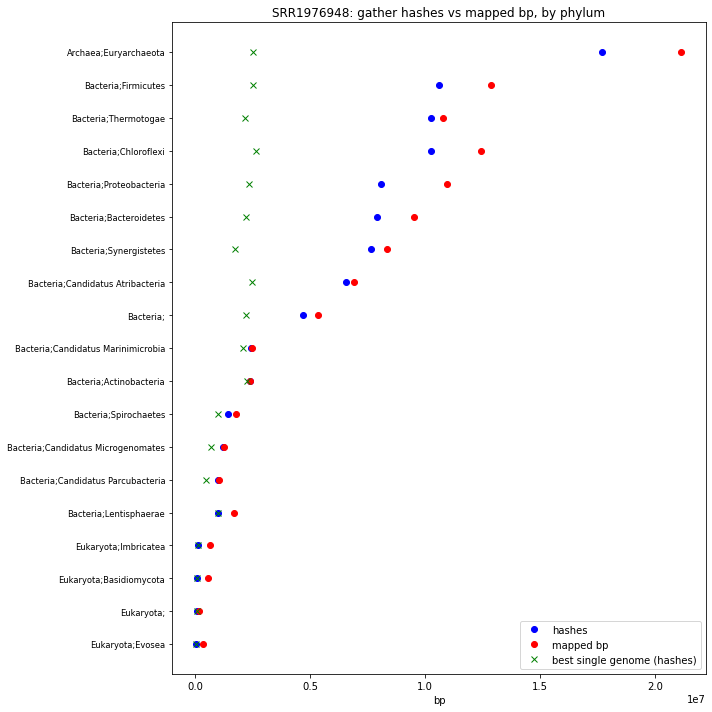

In [25]:
rank = 'phylum'

pylab.figure(num=None, figsize=(10, 10))

rank_counts_df = aggregate_by_rank(merged_lin_df, rank)

plot_df = rank_counts_df[:40]
pylab.plot(plot_df.hashes, plot_df.iloc[::-1].index, 'bo', label='hashes')
pylab.plot(plot_df.mapped, plot_df.iloc[::-1].index, 'ro', label='mapped bp')
pylab.plot(plot_df.best_hashes, plot_df.iloc[::-1].index, 'gx', label='best single genome (hashes)')

positions = list(plot_df.index)
labels = list(reversed(plot_df.name))
pylab.yticks(positions, labels, fontsize='small')

pylab.xlabel('bp')
pylab.legend(loc='lower right')
pylab.title(f'{sample_id}: gather hashes vs mapped bp, by {rank}')
pylab.tight_layout()

figname = f'/tmp/gathertax-{rank}-{sample_id}.png'
print(f'saving to {figname}')
pylab.savefig(figname)